to clean up the code from the other week 5 notebooks and maybe play with the models a bit!

In [1]:
import uproot as ur
import awkward as ak
import numpy as np

data_path = '/fast_scratch/atlas_images/v01-45/'

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/Users/swiatlow/Code/ML4P/LCStudies')
sys.path.append('/home/mswiatlowski/start_tf/LCStudies')
import graph_util as gu
import plot_util as pu

In [3]:
#first: data processing: (careful she takes a long time)
path_pipm = data_path + 'pipm_medium.root'
path_pi0  = data_path + 'pi0_medium.root'

tree_pipm = ur.open(path_pipm)['EventTree']
tree_pi0  = ur.open(path_pi0)['EventTree']

geoDict_tree_pipm = ur.open(path_pipm)['CellGeo']
geoDict_tree_pi0  = ur.open(path_pi0)["CellGeo"]

cell_id_pipm = gu.loadArrayBranchFlat('cluster_cell_ID', tree_pipm, 2000)
cell_e_pipm = gu.loadArrayBranchFlat('cluster_cell_E', tree_pipm, 2000)
cell_id_pi0 = gu.loadArrayBranchFlat('cluster_cell_ID', tree_pi0, 2000)
cell_e_pi0 = gu.loadArrayBranchFlat('cluster_cell_E', tree_pi0, 2000)

geoDict_pipm = gu.loadGraphDictionary(geoDict_tree_pipm)
geoDict_pi0  = gu.loadGraphDictionary(geoDict_tree_pi0)

cell_phi_pipm = gu.convertIDToGeo(cell_id_pipm, 'cell_geo_phi', geoDict_pipm)
cell_eta_pipm = gu.convertIDToGeo(cell_id_pipm, 'cell_geo_eta', geoDict_pipm)
cell_phi_pi0 = gu.convertIDToGeo(cell_id_pi0, 'cell_geo_phi', geoDict_pi0)
cell_eta_pi0 = gu.convertIDToGeo(cell_id_pi0, 'cell_geo_eta', geoDict_pi0)

clus_eta_pipm = gu.loadVectorBranchFlat('cluster_Eta', tree_pipm)
clus_E_pipm = gu.loadVectorBranchFlat('cluster_E', tree_pipm)

clus_eta_pi0 = gu.loadVectorBranchFlat('cluster_Eta', tree_pi0)
clus_E_pi0 = gu.loadVectorBranchFlat('cluster_E', tree_pi0)

clus_phi_pipm = gu.loadVectorBranchFlat('cluster_Phi', tree_pipm)
clus_phi_pi0  = gu.loadVectorBranchFlat('cluster_Phi', tree_pi0)

In [4]:
#HERE: change the eta cuts!
eta_mask_pipm = (abs(clus_eta_pipm) > 2.5) & (abs(clus_eta_pipm) < 3.1)
eta_mask_pi0  = (abs(clus_eta_pi0) > 2.5) & (abs(clus_eta_pi0) < 3.1)

energy_mask_pipm = clus_E_pipm > 0.5
energy_mask_pi0 = clus_E_pi0 > 0.5

selection_pipm = eta_mask_pipm & energy_mask_pipm
selection_pi0 = eta_mask_pi0 & energy_mask_pi0

In [5]:
#dont rerun
cell_eta_norm_pipm = np.nan_to_num(cell_eta_pipm - clus_eta_pipm[:, None])
cell_eta_norm_pi0 = np.nan_to_num(cell_eta_pi0 - clus_eta_pi0[:, None])
cell_phi_norm_pipm = np.nan_to_num(cell_phi_pipm - clus_phi_pipm[:, None])
cell_phi_norm_pi0 = np.nan_to_num(cell_phi_pi0 - clus_phi_pi0[:, None])

cell_e_norm_pipm = np.nan_to_num(np.log(cell_e_pipm), posinf = 0, neginf=0)
cell_e_norm_pi0 = np.nan_to_num(np.log(cell_e_pi0), posinf = 0, neginf=0)

# Working after some careful manipulation of the masks
cell_samp_pipm = gu.convertIDToGeo(cell_id_pipm, 'cell_geo_sampling', geoDict_pipm)
cell_samp_pi0 = gu.convertIDToGeo(cell_id_pi0, 'cell_geo_sampling', geoDict_pi0)

#normalize to a lower value fairly arbitrarily
cell_samp_norm_pipm = cell_samp_pipm * 0.1
cell_samp_norm_pi0 = cell_samp_pi0 * 0.1


<ipython-input-5-9ca06993e40d>:7: RuntimeWarning: divide by zero encountered in log
  cell_e_norm_pipm = np.nan_to_num(np.log(cell_e_pipm), posinf = 0, neginf=0)
<ipython-input-5-9ca06993e40d>:8: RuntimeWarning: divide by zero encountered in log
  cell_e_norm_pi0 = np.nan_to_num(np.log(cell_e_pi0), posinf = 0, neginf=0)


In [6]:
#rerun!!!
X_pipm = np.stack((cell_e_norm_pipm[selection_pipm], cell_eta_norm_pipm[selection_pipm], cell_phi_norm_pipm[selection_pipm], cell_samp_norm_pipm[selection_pipm]), axis = 2)
X_pi0  = np.stack((cell_e_norm_pi0[selection_pi0], cell_eta_norm_pi0[selection_pi0], cell_phi_norm_pi0[selection_pi0], cell_samp_norm_pi0[selection_pi0]), axis = 2)
X = np.concatenate((X_pipm[:36000], X_pi0[:36000]))
Y = tf.keras.utils.to_categorical(np.concatenate((np.ones(36000), np.zeros(36000)))) #one hot
print(len(X), len(Y))

72000 72000


In [21]:
def modelNmetrics(X, Y, batch_size):
    Phi_sizes, F_sizes = (200, 200, 256), (100, 100, 100)
    print('sizes: X ', len(X), 'Y: ', len(Y))
    # do train/val/test split 
    (X_train, X_val, X_test, Y_train, Y_val, Y_test) = data_split(X, Y, val=10000, test=15000)

    #make the model:
    pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

    # train model
    history = pfn.fit(X_train, Y_train, epochs=200, batch_size=batch_size, validation_data=(X_val, Y_val), verbose=1)
    
    preds = pfn.predict(X_test, batch_size=1000)
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])
    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print('PFN AUC:', auc)
   
    return history, pfn_fp, pfn_tp, auc

In [18]:
hist1, fp1, tp1, auc1 = modelNmetrics(X,Y, 100)

sizes: X  72000 Y:  72000
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_14 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_14[0][0]              
__________________________________________________________________

In [19]:
hist10, fp10, tp10, auc10 = modelNmetrics(X,Y, 1000)

sizes: X  72000 Y:  72000
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_21 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_21[0][0]              
__________________________________________________________________

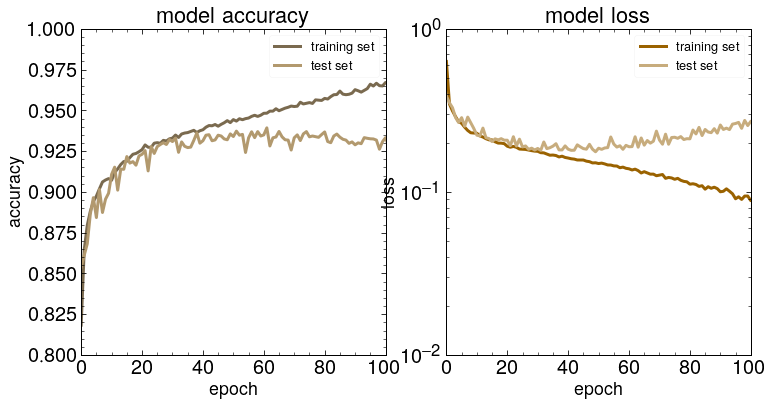

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[12,6])
ax1.set_xlim(0,100)
ax1.plot(hist1.history['acc'], label='training set', c='xkcd:greyish brown', linewidth=3)
ax1.plot(hist1.history['val_acc'], label='test set', c='xkcd:dust', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()

ax2.set_xlim(0,100)
ax2.plot(hist1.history['loss'], label='training set', c='xkcd:raw sienna', linewidth=3)
ax2.plot(hist1.history['val_loss'], label='test set', c='xkcd:toupe', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.set_yscale('log')
ax2.legend()


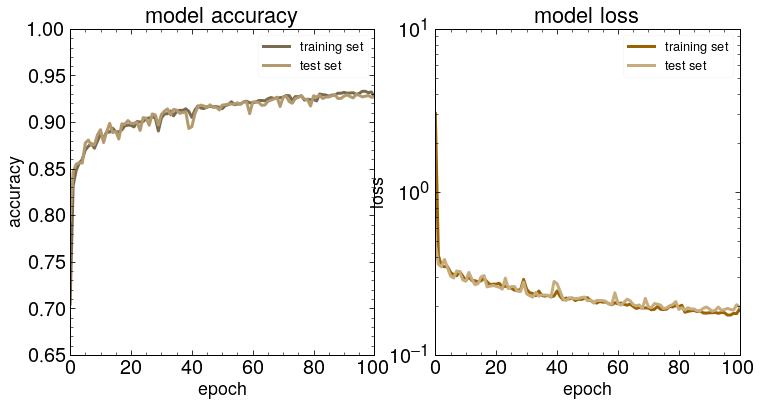

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[12,6])
ax1.set_xlim(0,100)
ax1.plot(hist10.history['acc'], label='training set', c='xkcd:greyish brown', linewidth=3)
ax1.plot(hist10.history['val_acc'], label='test set', c='xkcd:dust', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()

ax2.set_xlim(0,100)
ax2.plot(hist10.history['loss'], label='training set', c='xkcd:raw sienna', linewidth=3)
ax2.plot(hist10.history['val_loss'], label='test set', c='xkcd:toupe', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.set_yscale('log')
ax2.legend()#so larger batch size helps with overfitting!!!


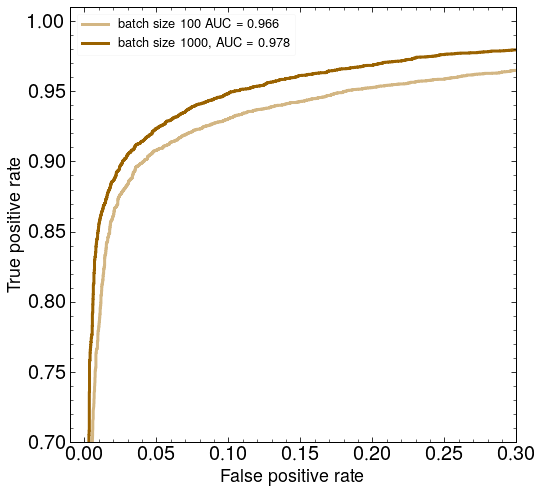

In [24]:
plt.figure(figsize=[8,8])
plt.ylim(.7, 1.01)
plt.xlim(-.01, .3)
plt.plot(fp1, tp1, label='batch size 100 AUC = %.3f'%auc1, linewidth=3, c='xkcd:very light brown')
plt.plot(fp10, tp10, label='batch size 1000, AUC = %.3f'%auc10, linewidth=3, c='xkcd:raw sienna')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()


In [8]:
hist12, fp12, tp12, auc12 = modelNmetrics(X,Y, 1200)

sizes: X  72000 Y:  72000
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
____________________________________________________________________

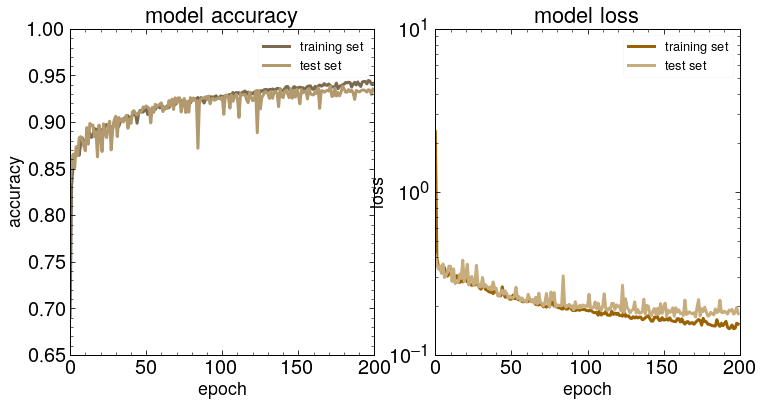

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[12,6])
ax1.set_xlim(0,200)
ax1.plot(hist12.history['acc'], label='training set', c='xkcd:greyish brown', linewidth=3)
ax1.plot(hist12.history['val_acc'], label='test set', c='xkcd:dust', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()

ax2.set_xlim(0,200)
ax2.plot(hist12.history['loss'], label='training set', c='xkcd:raw sienna', linewidth=3)
ax2.plot(hist12.history['val_loss'], label='test set', c='xkcd:toupe', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.set_yscale('log')
ax2.legend()#so larger batch size helps with overfitting!!!

In [11]:
hist12, fp12, tp12, auc12 = modelNmetrics(X,Y, 2000)

sizes: X  72000 Y:  72000
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_7 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_7[0][0]               
__________________________________________________________________

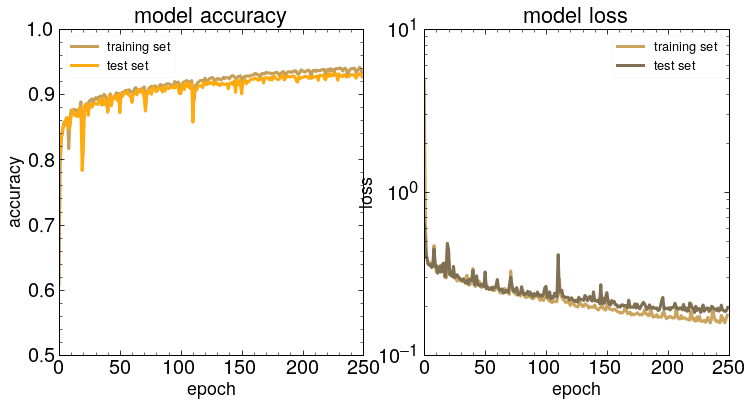

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[12,6])
ax1.set_xlim(0,250)
ax1.plot(hist12.history['acc'], label='training set', c='xkcd:camel', linewidth=3)
ax1.plot(hist12.history['val_acc'], label='test set', c='xkcd:yellowish orange', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()

ax2.set_xlim(0,250)
ax2.plot(hist12.history['loss'], label='training set', c='xkcd:sand brown', linewidth=3)
ax2.plot(hist12.history['val_loss'], label='test set', c='xkcd:grey brown', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.set_yscale('log')
ax2.legend()#so larger batch size helps with overfitting!!!

In [18]:
hist2phi, fp2phi, tp2phi, auc2phi = modelNmetrics(X,Y, 1000) #with F**** sizes doubled, not sure why doubling phi sizes gets a resource exhausted error... maybe could fix with smaller batches?

sizes: X  72000 Y:  72000
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_28 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_28[0][0]              
__________________________________________________________________

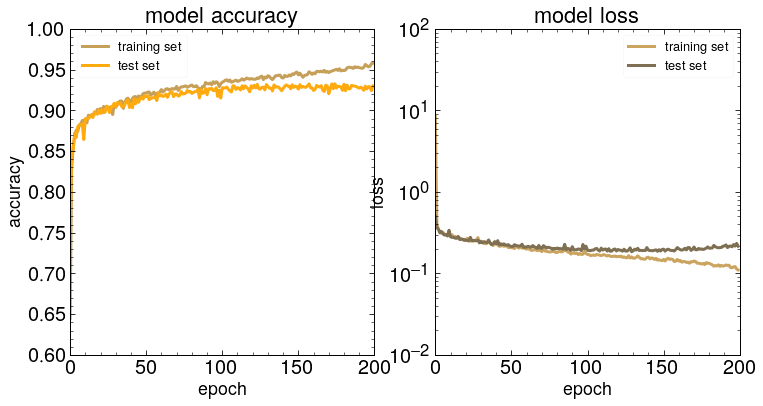

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[12,6])
ax1.set_xlim(0,200)
ax1.plot(hist2phi.history['acc'], label='training set', c='xkcd:camel', linewidth=3)
ax1.plot(hist2phi.history['val_acc'], label='test set', c='xkcd:yellowish orange', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()

ax2.set_xlim(0,200)
ax2.plot(hist2phi.history['loss'], label='training set', c='xkcd:sand brown', linewidth=3)
ax2.plot(hist2phi.history['val_loss'], label='test set', c='xkcd:grey brown', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.set_yscale('log')
ax2.legend()#so larger batch size helps with overfitting!!!

In [22]:
hist2phifr, fp2phifr, tp2phifr, auc2phifr = modelNmetrics(X,Y, 500) #fr as in like for real this time lol
#ah okay so I was right, doubling phi doesn't work with such a large batch size but halving the batch size and doubling phi worked.

sizes: X  72000 Y:  72000
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 200)    1000        input[0][0]                      
__________________________________________________________________________________________________
activation_35 (Activation)      (None, None, 200)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 200)    40200       activation_35[0][0]              
__________________________________________________________________

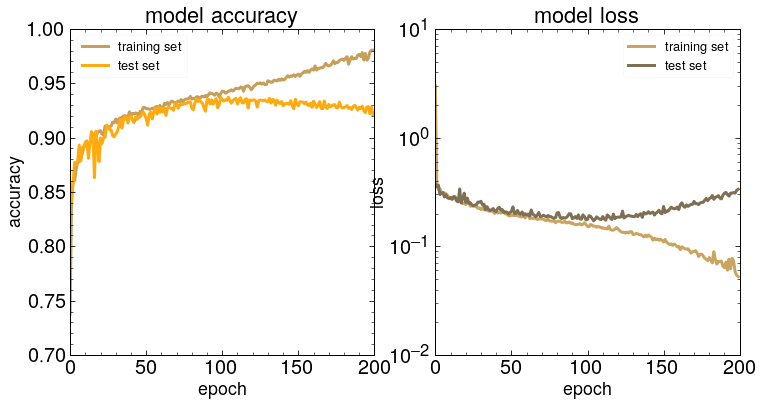

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[12,6])
ax1.set_xlim(0,200)
ax1.plot(hist2phifr.history['acc'], label='training set', c='xkcd:camel', linewidth=3)
ax1.plot(hist2phifr.history['val_acc'], label='test set', c='xkcd:yellowish orange', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()

ax2.set_xlim(0,200)
ax2.plot(hist2phifr.history['loss'], label='training set', c='xkcd:sand brown', linewidth=3)
ax2.plot(hist2phifr.history['val_loss'], label='test set', c='xkcd:grey brown', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.set_yscale('log')
ax2.legend()#okayso this is clearly worse

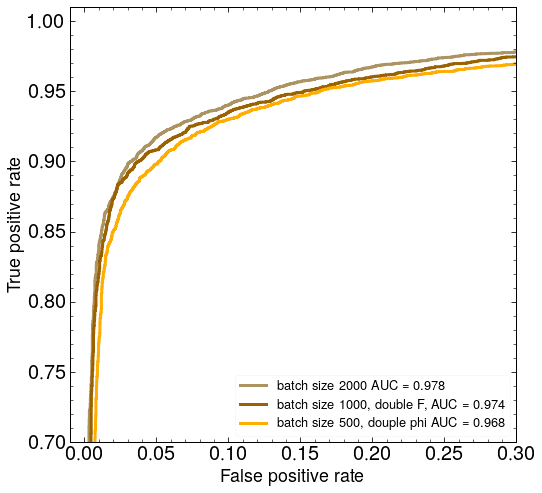

In [26]:
plt.figure(figsize=[8,8])
plt.ylim(.7, 1.01)
plt.xlim(-.01, .3)
plt.plot(fp12, tp12, label='batch size 2000 AUC = %.3f'%auc12, linewidth=3, c='xkcd:dark beige')
plt.plot(fp2phi, tp2phi, label='batch size 1000, double F, AUC = %.3f'%auc2phi, linewidth=3, c='xkcd:raw sienna')
plt.plot(fp2phifr, tp2phifr, label='batch size 500, douple phi AUC = %.3f'%auc2phifr, linewidth=3, c='xkcd:orange yellow')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
